# **DataCollection**

## Objectives

- Fetch data from Kaggle, save as raw data and prepare it for further processes.

## Inputs

- Kaggle JSON file - the token is required for kaggle authentication. 

## Outputs

- Generate the Dataset: inputs/cherry_leaves_dataset.

## Additional Comments

- No additional comments here.


---


# Import packages

In [6]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib
from matplotlib.image import imread

Set Working Directory

In [7]:
cwd= os.getcwd()


You set a new current directory

In [9]:
os.chdir('/workspace/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory



Confirm the new current directory

In [10]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection-in-cherry-leaves'

---


# Set Input Directories

Sets the train, test and validation paths

In [11]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
valid_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'


Set output directory

In [12]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


Set label names

In [13]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']



Set image shape

In [14]:
import joblib

version = 'v1'
img_shape = joblib.load(filename=f"outputs/{version}/img_shape.pkl")
img_shape

(256, 256, 3)

---


# Images Distribution

These plots will give you a comprehensive view of your dataset's distribution across different labels and sets, which is essential for understanding data balance and preparing for model training.

## Count Number of Images per Set & Label

* train - healthy: 736 images
* train - powdery_mildew: 736 images
* validation - healthy: 105 images
* validation - powdery_mildew: 105 images
* test - healthy: 211 images
* test - powdery_mildew: 211 images




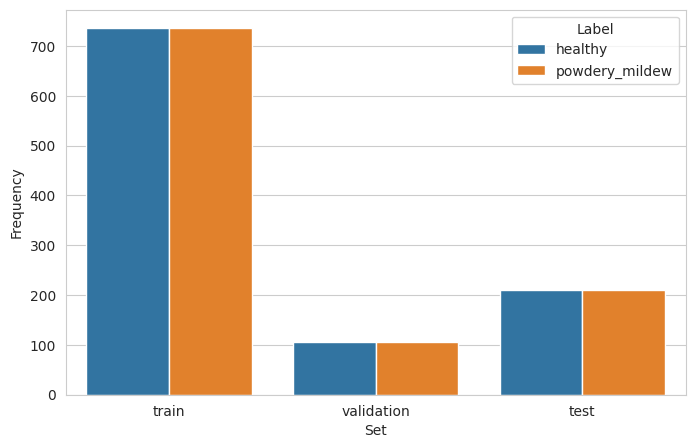

In [15]:

df_img_freq = pd.DataFrame([])

for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_img_freq = df_img_freq.append(
            pd.Series(
                data={
                    'Set': folder,
                    'Label': label,
                    'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
                }
            ),
            ignore_index=True
        )

        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_img_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/label_dist.png', bbox_inches='tight', dpi=150)
plt.show()

---


# Image Data Augmentation

--- 


Import ImageDataGenerator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



Initialize ImageDataGenerator

In [17]:
augmented_img_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

Augment Training Image Set

In [18]:

batch_size = 1
train_set = augmented_img_data.flow_from_directory(
    train_path, 
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

train_set.class_indices

Found 1472 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}


Augment validation Image Set

In [19]:

validation_img_data = ImageDataGenerator(rescale=1./255)
validation_set = validation_img_data.flow_from_directory(
    valid_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

validation_set.class_indices

Found 210 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}


Augment Test Image Set

In [20]:
test_img_data = ImageDataGenerator(rescale=1./255)
test_set = test_img_data.flow_from_directory(                       
    test_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_set.class_indices

Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}


Plot Augmented Training Image Set

(1, 256, 256, 3)


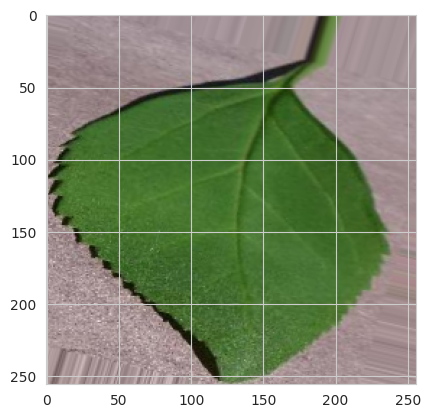

(1, 256, 256, 3)


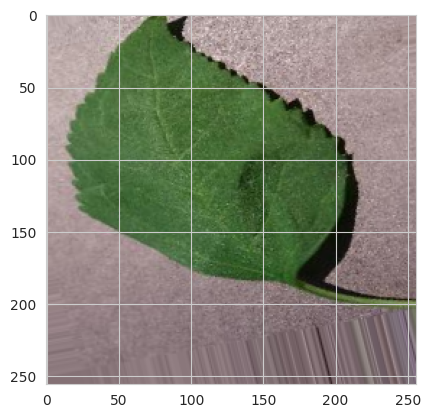

(1, 256, 256, 3)


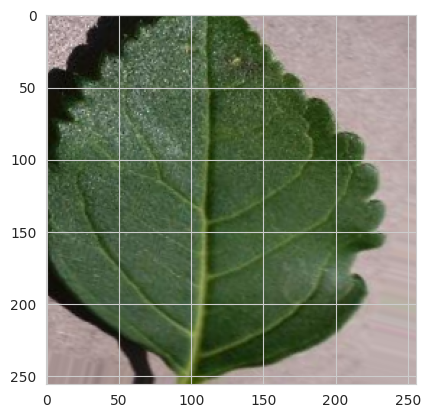

(1, 256, 256, 3)


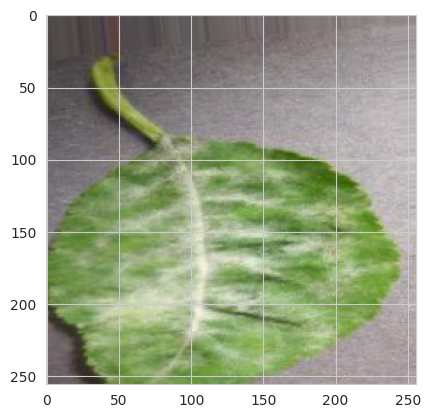

In [21]:
for _ in range(4):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Plot Augmented Validation Image Set

(1, 256, 256, 3)


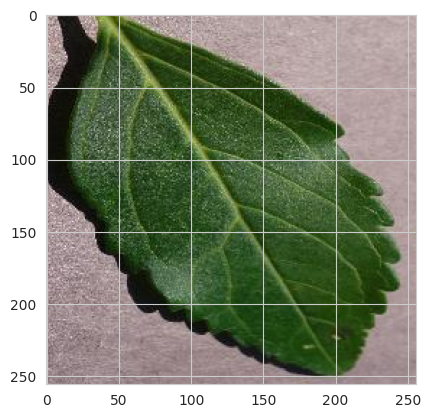

(1, 256, 256, 3)


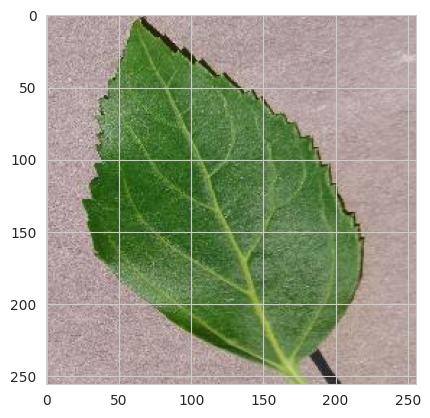

(1, 256, 256, 3)


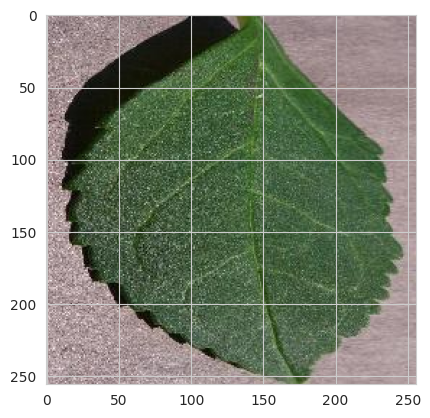

(1, 256, 256, 3)


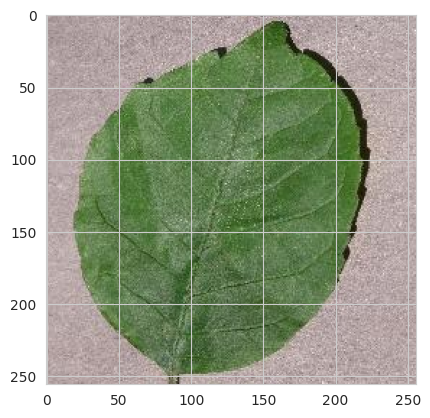

In [22]:
for _ in range(4):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


Plot Augmented Test Image Set

(1, 256, 256, 3)


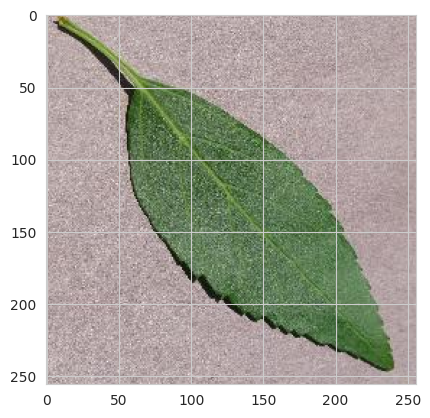

(1, 256, 256, 3)


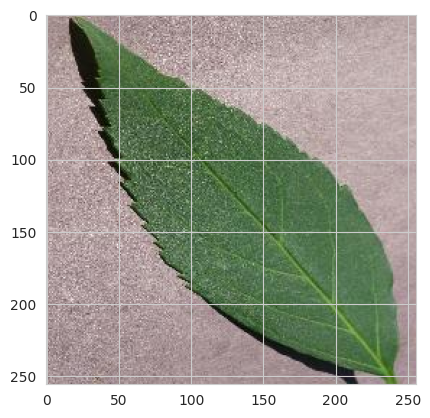

(1, 256, 256, 3)


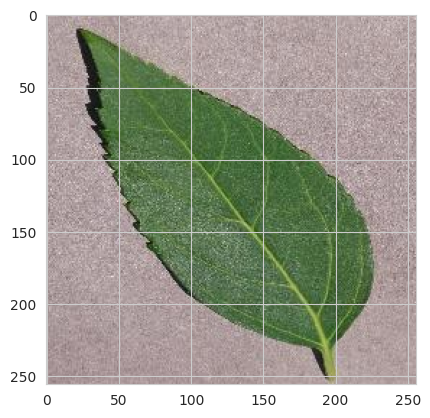

(1, 256, 256, 3)


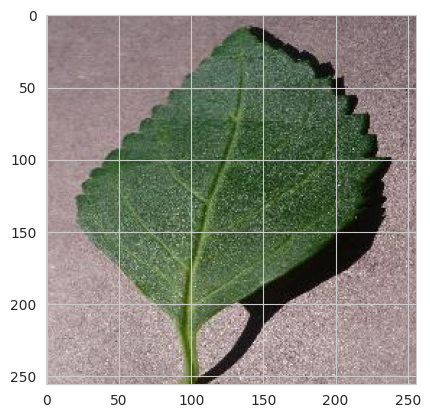

In [23]:
for _ in range(4):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()


Save class_indices

In [24]:

joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']